Скачать весь датасет (~5 Гб) можно по этой ссылке: https://drive.google.com/file/d/1CUZnBtYwifVXS21yVg62T-vrPVayso5H/view Файл с отсутствующими скелетами: https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p /content/data
!cp /content/drive/MyDrive/PyTorch/skeleton-data/nturgbd_skeletons_s001_to_s017.zip /content/data/data.zip

In [3]:
!rm -rf /content/data/nturgb+d_skeletons

In [4]:
!unzip -q /content/data/data.zip -d /content/data/

In [5]:
!wget https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
!cp /content/NTU_RGBD_samples_with_missing_skeletons.txt /content/data/with_missing_skeletons.txt

--2020-12-07 10:10:43--  https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘NTU_RGBD_samples_with_missing_skeletons.txt’

NTU_RGBD_samples_wi     [ <=>                ] 155.09K  --.-KB/s    in 0.02s   

2020-12-07 10:10:43 (6.29 MB/s) - ‘NTU_RGBD_samples_with_missing_skeletons.txt’ saved [158817]



Собрать класс датасет с функциями из ноутбука по генерации датасета. Надо функции перенести в класс + добавить возможность при инициализации менять длину последовательности кадров.

In [6]:
import os

import numpy as np
import pandas as pd

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [7]:
class Croped_Data:
    def __init__(self, data_path, broken_files_path):
        subjects = list(range(0, 28)) #количество людей выполняющих действия
        classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        cameras = [1, 2, 3] 
        max_count = 120  

        labels = []
        counter = 0
        files_counter = {}
        
        self.__files = []
        self.__action_classes = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in classes and camera_id in cameras:  #and subject_id in subjects:
                    
                    if action_class in self.__action_classes:
                        if files_counter[action_class] < max_count:
                            self.__files.append([filename, self.__action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        self.__action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter += 1
                        self.__files.append([filename, self.__action_classes[action_class]])

    def get_files(self):
        return self.__files
    
    
    def get_classes(self):
        return self.__action_classes

In [8]:
data_path = "/content/data/nturgb+d_skeletons/"
broken_files_path = "/content/data/with_missing_skeletons.txt"

data = Croped_Data(data_path, broken_files_path)

In [9]:
# data.get_classes()

In [10]:
# numbers = {v: 0 for k, v in data.get_classes().items()}
# numbers

In [11]:
# len(data.get_files())

In [12]:
# data.get_files()

In [13]:
# a, b = torch.utils.data.random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
# print(a)

In [14]:
class Skeleton_Dataset(Dataset):
    def __init__(self, 
                 inc_data, 
                 data_path, 
                 transform=None, 
                 chonk_len=45):
        
        self.transform = transform
        self.chonk_len = chonk_len
        self.data_path = data_path

        data_lst = []
        labels_lst = []
        numbers = {v: 0 for k, v in inc_data.get_classes().items()}

        for file in inc_data.get_files():
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data_lst = data_lst + frames_blocks
                labels_lst = labels_lst + label
        
        data_np = np.asarray(data_lst)
        labels_np = np.asarray(labels_lst)

        data_sq = data_np.reshape(len(data_np), -1)
        self.data = pd.DataFrame(data_sq)
        self.data['labels'] = labels_np
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.chonk_len, 25*3)
        label = self.labels.values[idx]
        if self.transform != None:
            item = self.transform(item)
        return (item, label)
    
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence


    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]
        return data


    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []

        return blocks, new_labels

In [15]:
dataset = Skeleton_Dataset(data, data_path)

In [16]:
dataset.data[:int(0.75*len(dataset.data))].shape

(579, 3376)

In [17]:
label = dataset.labels.values[41]
label

4

In [18]:
skel, lab = dataset.__getitem__(41)

In [19]:
lab

4

In [20]:
skel.shape

(45, 75)

In [21]:
action_classes = [
    "drink water",
    "eat meal/snack",
    "brushing teeth",
    "brushing hair",
    "drop",
    "pickup",
    "throw",
    "sitting down",
    "standing up (from sitting position)",
    "clapping",
    "reading",
    "writing",
    "tear up paper",
    "wear jacket",
    "take off jacket",
    "wear a shoe",
    "take off a shoe",
    "wear on glasses",
    "take off glasses",
    "put on a hat/cap",
    "take off a hat/cap",
    "cheer up",
    "hand waving",
    "kicking something",
    "reach into pocket",
    "hopping (one foot jumping)",
    "jump up",
    "make a phone call/answer phone",
    "playing with phone/tablet",
    "typing on a keyboard",
    "pointing to something with finger",
    "taking a selfie",
    "check time (from watch)",
    "rub two hands together",
    "nod head/bow",
    "shake head",
    "wipe face",
    "salute",
    "put the palms together",
    "cross hands in front (say stop)",
    "sneeze/cough",
    "staggering",
    "falling",
    "touch head (headache)",
    "touch chest (stomachache/heart pain)",
    "touch back (backache)",
    "touch neck (neckache)",
    "nausea or vomiting condition",
    "use a fan (with hand or paper)/feeling warm",
    "punching/slapping other person",
    "kicking other person",
    "pushing other person",
    "pat on back of other person",
    "point finger at the other person",
    "hugging other person",
    "giving something to other person",
    "touch other person's pocket",
    "handshaking",
    "walking towards each other",
    "walking apart from each other",
    "put on headphone",
    "take off headphone",
    "shoot at the basket",
    "bounce ball",
    "tennis bat swing",
    "juggling table tennis balls",
    "hush (quite)",
    "flick hair",
    "thumb up",
    "thumb down",
    "make ok sign",
    "make victory sign",
    "staple book",
    "counting money",
    "cutting nails",
    "cutting paper (using scissors)",
    "snapping fingers",
    "open bottle",
    "sniff (smell)",
    "squat down",
    "toss a coin",
    "fold paper",
    "ball up paper",
    "play magic cube",
    "apply cream on face",
    "apply cream on hand back",
    "put on bag",
    "take off bag",
    "put something into a bag",
    "take something out of a bag",
    "open a box",
    "move heavy objects",
    "shake fist",
    "throw up cap/hat",
    "hands up (both hands)",
    "cross arms",
    "arm circles",
    "arm swings",
    "running on the spot",
    "butt kicks (kick backward)",
    "cross toe touch",
    "side kick",
    "yawn",
    "stretch oneself",
    "blow nose",
    "hit other person with something",
    "wield knife towards other person",
    "knock over other person (hit with body)",
    "grab other person’s stuff",
    "shoot at other person with a gun",
    "step on foot",
    "high-five",
    "cheers and drink",
    "carry something with other person",
    "take a photo of other person",
    "follow other person",
    "whisper in other person’s ear",
    "exchange things with other person",
    "support somebody with hand",
    "finger-guessing game (playing rock-paper-scissors)"
]

classes = [8, 10, 22, 23, 27, 21]    
LABELS = {i: action_classes[classes[i]] for i in range(len(classes))}
LABELS

{0: 'standing up (from sitting position)',
 1: 'reading',
 2: 'hand waving',
 3: 'kicking something',
 4: 'make a phone call/answer phone',
 5: 'cheer up'}

In [22]:
# lab

In [23]:
# LABELS[lab]

Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)

In [24]:

class LSTM_net(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [25]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [26]:

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [27]:

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

45 кадров

In [28]:

split_train_part = 0.75
train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [29]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7975  / cheer up ✗ (standing up (from sitting position))
epoch : 13 iter : 19 (0m 13s) 1.7831  / cheer up ✗ (kicking something)
epoch : 27 iter : 1 (0m 27s) 1.6283  / cheer up ✓
epoch : 40 iter : 20 (0m 40s) 1.5416  / cheer up ✗ (hand waving)
epoch : 54 iter : 2 (0m 54s) 1.3505  / standing up (from sitting position) ✓
epoch : 67 iter : 21 (1m 7s) 1.1447  / cheer up ✓
epoch : 81 iter : 3 (1m 21s) 1.5894  / kicking something ✗ (reading)
epoch : 94 iter : 22 (1m 34s) 1.2638  / standing up (from sitting position) ✗ (kicking something)
epoch : 108 iter : 4 (1m 48s) 1.2576  / reading ✓
epoch : 121 iter : 23 (2m 1s) 1.2500  / kicking something ✗ (reading)
epoch : 135 iter : 5 (2m 15s) 0.8874  / standing up (from sitting position) ✗ (kicking something)
epoch : 148 iter : 24 (2m 29s) 0.5766  / standing up (from sitting position) ✗ (hand waving)
epoch : 162 iter : 6 (2m 42s) 0.7467  / cheer up ✓
epoch : 175 iter : 25 (2m 56s) 0.6789  / standing up (from sitting posit

35 кадров

In [30]:
data = Croped_Data(data_path, broken_files_path)
dataset_c35 = Skeleton_Dataset(data, data_path, chonk_len=35)

In [31]:

dataset_c35.data.shape

(901, 2626)

In [32]:

skel, lab = dataset_c35.__getitem__(41)

In [33]:

skel.shape

(35, 75)

In [34]:

lab

0

In [35]:

split_train_part = 0.75
train_dataset, test_dataset = torch.utils.data.random_split(dataset_c35, 
                                                            [int(split_train_part*dataset_c35.data.shape[0]), 
                                                             dataset_c35.data.shape[0] - int(split_train_part*dataset_c35.data.shape[0])], 
                                                            generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [36]:

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [37]:

from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7823  / kicking something ✓
epoch : 11 iter : 27 (0m 11s) 1.7571  / make a phone call/answer phone ✗ (kicking something)
epoch : 23 iter : 11 (0m 23s) 1.6503  / standing up (from sitting position) ✗ (cheer up)
epoch : 34 iter : 38 (0m 34s) 1.5891  / make a phone call/answer phone ✗ (standing up (from sitting position))
epoch : 46 iter : 22 (0m 46s) 1.1092  / make a phone call/answer phone ✓
epoch : 58 iter : 6 (0m 57s) 1.0133  / make a phone call/answer phone ✓
epoch : 69 iter : 33 (1m 9s) 1.4241  / make a phone call/answer phone ✓
epoch : 81 iter : 17 (1m 21s) 1.4845  / reading ✗ (hand waving)
epoch : 93 iter : 1 (1m 32s) 1.1002  / kicking something ✗ (standing up (from sitting position))
epoch : 104 iter : 28 (1m 44s) 0.8379  / cheer up ✓
epoch : 116 iter : 12 (1m 55s) 1.4384  / reading ✗ (kicking something)
epoch : 127 iter : 39 (2m 7s) 0.9822  / standing up (from sitting position) ✓
epoch : 139 iter : 23 (2m 18s) 0.8927  / reading ✗ (cheer up)
epoch : 1

Перебор вариантов: 30 - 45 кадров, 1-4 LSTM слоёв

In [38]:
import math

class HyperParSearchDec:
    
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = None
        self.summary_data = pd.DataFrame(data=[[0, 0, 0, 0]], 
                            columns=['layer', 'chonk', 'loss', 'accuracy'])
        self.chonk = np.arange(30, 46, 5)
        self.layer = np.arange(4) + 1
        self.epochs = 200
        self.data_path = "/content/data/nturgb+d_skeletons/"
        broken_files_path = "/content/data/with_missing_skeletons.txt"

        self.data = Croped_Data(self.data_path, broken_files_path)
        self.prev_chonk = 0
        self.train_ld = None

    
    def depoch(self, optimizer, criterion, ep_loss_list, ep_acc_list):
      loss_list = []
      acc_list = []
      counter = 0

      for i, data in enumerate(self.train_ld, 0):
          inputs, labels = data[0].to(device), data[1].to(device)

          # обнуляем градиент
          optimizer.zero_grad()

          outputs = self.net(inputs.float())
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          category = LABELS[int(labels[0])]

          # выводим статистику о процессе обучения
          loss_list.append(loss.item())

          # Отслеживание точности
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_list.append(correct / total)
          
      ep_loss_list.append(sum(loss_list) / len(loss_list))
      ep_acc_list.append(sum(acc_list) / len(acc_list))
      counter = counter + 1
      if counter % 25 == 0:
          print(f"\tepoch: {epoch+1}\tloss: {ep_loss_list[-1]:.6f}\taccuracy: {ep_acc_list[-1]*100:.3f}%")
      return ep_loss_list, ep_acc_list  
    
    
    def dsample(self, chonk):
        criterion = nn.CrossEntropyLoss()
        learning_rate = 0.0007
        optimizer = optim.SGD(self.net.parameters(), lr=learning_rate, momentum=0.9)

        ep_loss_list = []
        ep_acc_list = []
        start = time.time()
        counter = 0
        
        split_train_part = 0.75
        if self.prev_chonk != chonk:
            dataset = Skeleton_Dataset(self.data, self.data_path, chonk_len=chonk)
            train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                        [int(split_train_part*dataset.data.shape[0]), 
                                                                         dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])], 
                                                                        generator=torch.Generator().manual_seed(42))
            self.train_ld = DataLoader(train_dataset, batch_size = 16, shuffle=True)
            self.prev_chonk = chonk
        
        for epoch in range(self.epochs):
            ep_loss_list, ep_acc_list = self.depoch(optimizer, criterion, ep_loss_list, ep_acc_list)
        return ep_loss_list, ep_acc_list
        
        
    def grid_search(self):
        cnt = 0
        
        path_dir = '/content/drive/MyDrive/PyTorch/HW2/net_lstm'
        if not os.path.exists(path_dir):
            os.mkdir(path_dir)
        
        for n_ch in self.chonk:
            for n_la in self.layer:
                print(f"\nМодель: слоёв lstm: {n_la}, кадров: {n_ch}\n")
                n_hidden = 128
                n_joints = 25*3
                n_categories = len(LABELS)
                self.net = LSTM_net(n_joints, n_hidden, n_categories, n_la).to(self.device)

                loss_t, acc_t = self.dsample(n_ch)
                loss = loss_t[-1]
                acc = acc_t[-1]
                torch.save(self.net.state_dict(), f'/content/drive/MyDrive/PyTorch/HW2/net_lstm/op_net_lstm_{n_la}_chonk_{n_ch}.pth')

                print(f"\tОшибки на train: {loss:.5f}")
                print(f"\tAccuracy на train: {acc:.5f}")
                self.summary_data.loc[cnt, ['layer', 'chonk', 'loss', 'accuracy']] = [n_la, n_ch, loss, acc]
                cnt += 1
                
    def categoryFromOutput(self, output):
        top_n, top_i = output.topk(1)
        category_i = top_i[0].item()
    #     print(output.topk(5))
        return LABELS[category_i], category_i

    def timeSince(self, since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

In [39]:

search_top = HyperParSearchDec()

In [40]:

search_top.grid_search()


Модель: слоёв lstm: 1, кадров: 30

	Ошибки на train: 0.78111
	Accuracy на train: 0.70957

Модель: слоёв lstm: 2, кадров: 30

	Ошибки на train: 0.81771
	Accuracy на train: 0.70005

Модель: слоёв lstm: 3, кадров: 30

	Ошибки на train: 1.18486
	Accuracy на train: 0.52497

Модель: слоёв lstm: 4, кадров: 30

	Ошибки на train: 1.73833
	Accuracy на train: 0.29043

Модель: слоёв lstm: 1, кадров: 35

	Ошибки на train: 0.90694
	Accuracy на train: 0.69283

Модель: слоёв lstm: 2, кадров: 35

	Ошибки на train: 0.80713
	Accuracy на train: 0.69041

Модель: слоёв lstm: 3, кадров: 35

	Ошибки на train: 1.15349
	Accuracy на train: 0.51163

Модель: слоёв lstm: 4, кадров: 35

	Ошибки на train: 1.40169
	Accuracy на train: 0.35804

Модель: слоёв lstm: 1, кадров: 40

	Ошибки на train: 0.78015
	Accuracy на train: 0.70610

Модель: слоёв lstm: 2, кадров: 40

	Ошибки на train: 0.68694
	Accuracy на train: 0.73598

Модель: слоёв lstm: 3, кадров: 40

	Ошибки на train: 1.10467
	Accuracy на train: 0.54573

Модель: с

In [41]:

# search_top.summary_data

In [42]:

search_top.summary_data.sort_values('accuracy', ascending=False)

,layer,chonk,loss,accuracy
9,2.0,40.0,0.686936,0.735976
13,2.0,45.0,0.705248,0.711712
0,1.0,30.0,0.781108,0.709567
8,1.0,40.0,0.780152,0.706098
1,2.0,30.0,0.817712,0.700053
12,1.0,45.0,0.832674,0.695383
4,1.0,35.0,0.906935,0.692829
5,2.0,35.0,0.807131,0.690407
10,3.0,40.0,1.104669,0.545732
2,3.0,30.0,1.184862,0.524974


In [43]:

search_top.summary_data.to_csv("/content/drive/MyDrive/PyTorch/HW2/summary_data.csv", index=False)

In [44]:
sum_dat = search_top.summary_data


Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)

Text(0.5, 0, 'Количество кадров')

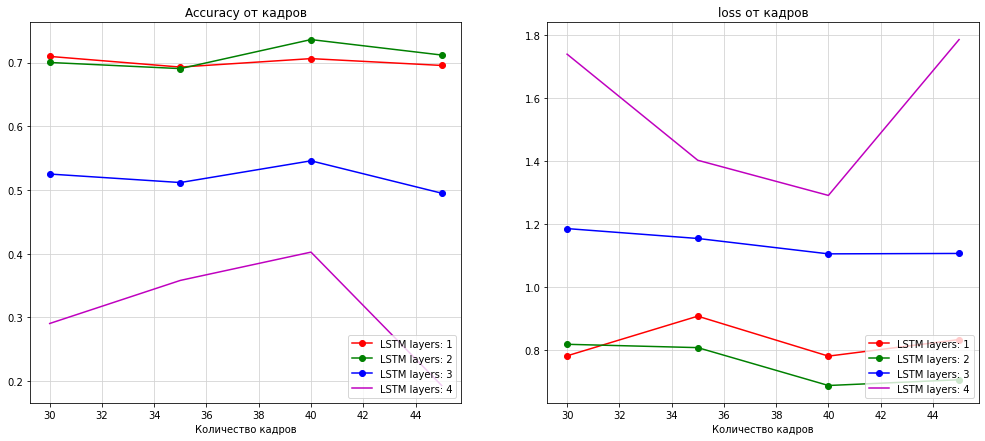

In [45]:
import matplotlib.pyplot as plt

fig0, axes0 = plt.subplots(1, 2, figsize=(17, 7))

color_list = ['ro-', 'go-', 'bo-', 'm']

for i in range(4):
    axes0[0].plot(np.arange(30, 46, 5),  sum_dat.loc[sum_dat['layer'] == i+1, "accuracy"].values, color_list[i], label="LSTM layers: " + str(i+1))
    axes0[1].plot(np.arange(30, 46, 5), sum_dat.loc[sum_dat['layer'] == i+1, "loss"].values, color_list[i], label="LSTM layers: " + str(i+1))

axes0[0].legend(loc="lower right")
axes0[0].grid(color="lightgrey")
axes0[0].set_title('Accuracy от кадров' )
axes0[0].set_xlabel("Количество кадров")
# axes0[0].уlabel("Accuracy")
# axes[0].show()

axes0[1].legend(loc="lower right")
axes0[1].grid(color="lightgrey")
axes0[1].set_title('loss от кадров' )
axes0[1].set_xlabel("Количество кадров")
# axes0[1].set_уlabel("Loss")

Построить график зависимости от количества модулей LSTM

In [46]:
chonk_list = np.arange(30, 46, 5)

for i in range(len(chonk_list)):
    print(sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "accuracy"].values)

[0.7095666  0.70005285 0.52497357 0.2904334 ]
[0.69282946 0.69040698 0.51162791 0.35804264]
[0.70609756 0.73597561 0.54573171 0.40243902]
[0.69538288 0.71171171 0.49493243 0.19313063]


Text(0.5, 0, 'Количество слоёв')

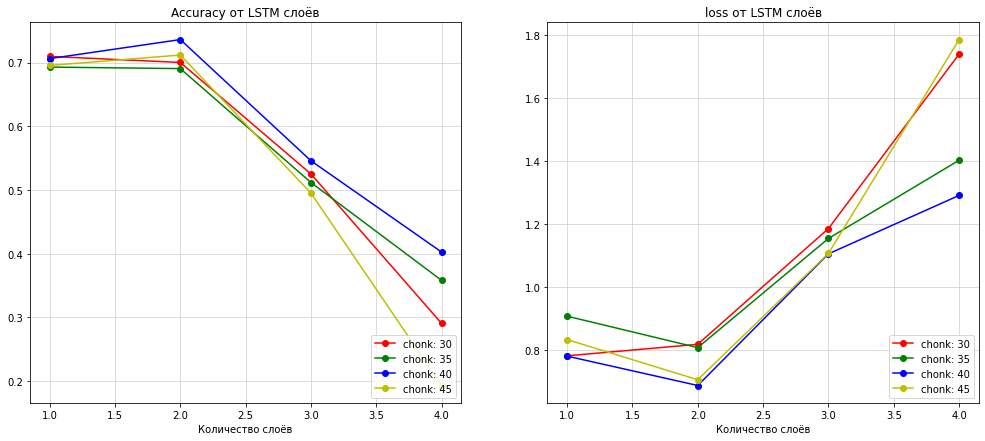

In [47]:
fig1, axes1 = plt.subplots(1, 2, figsize=(17, 7))

color_list_2 = ['ro-', 'go-', 'bo-', 'yo-']

for i in range(len(chonk_list)):
    axes1[0].plot(np.arange(4) + 1,  sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "accuracy"].values, color_list_2[i], label="chonk: " + str(chonk_list[i]))
    axes1[1].plot(np.arange(4) + 1,  sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "loss"].values, color_list_2[i], label="chonk: " + str(chonk_list[i]))

axes1[0].legend(loc="lower right")
axes1[0].grid(color="lightgrey")
axes1[0].set_title('Accuracy от LSTM слоёв' )
axes1[0].set_xlabel("Количество слоёв")

axes1[1].legend(loc="lower right")
axes1[1].grid(color="lightgrey")
axes1[1].set_title('loss от LSTM слоёв' )
axes1[1].set_xlabel("Количество слоёв")